## Visualization 1 – Example Brownian trajectory without traps

In this first figure we illustrate **pure diffusion** in two dimensions, without any traps.

- The particle undergoes **Brownian motion** in a square box \([0,L]\times[0,L]\) with *reflecting* boundaries.
- The diffusion coefficient is \(D = 0.1\), and the motion is simulated with small time steps \(\Delta t = 10^{-3}\) up to a final time \(T = 0.5\).
- There are **no traps** in this simulation (\(N_{\text{traps}} = 0\)), so the particle is never absorbed and explores the domain freely.

**What the plot shows**

- The **blue curve** is a single random trajectory \((x(t), y(t))\).
- The **green marker** indicates the **starting point** of the particle.
- The **red marker** indicates the **final position** at time \(T\).

Because there are no traps:

- The trajectory is a **continuous, irregular path** with no preferred direction.
- The particle is confined only by the reflecting boundaries, so the path bounces away from the edges but is otherwise unconstrained.
- This figure helps us build intuition about *ordinary* Brownian motion, before we introduce traps and study how they change the dynamics and the mean square displacement (MSD).

Later figures will reuse the same simulation framework but **add traps** and **average over many trajectories** to compute MSD and survival probability as a function of trap density.

Figure 1 – Example 2D Brownian trajectory in a square box with reflecting boundaries and no traps. The particle starts at the green point and ends at the red point after time 
T=0.5. The path shows the irregular wandering typical of Brownian motion.

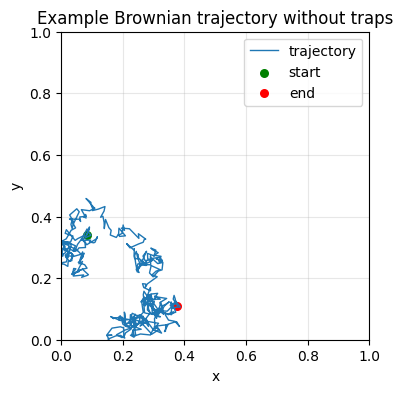

In [7]:
# ==============================================
# Visualization 1: single trajectory, no traps
# ==============================================

# No traps -> empty array of centers
traps_no = np.empty((0, 2))

# Simulate a single trajectory with no traps
positions_no, alive_no, t_death_idx_no = simulate_trajectory(
    L=L,
    D=D,
    dt=dt,
    n_steps=n_steps,
    traps=traps_no,
    trap_radius=trap_radius,  # not used since there are no traps
    rng=rng,
)

# Extract x and y coordinates
x_no = positions_no[:, 0]
y_no = positions_no[:, 1]

plt.figure(figsize=(4, 4))

# Plot the full trajectory
plt.plot(x_no, y_no, lw=1.0, label="trajectory")

# Mark starting point (green) and end point (red)
plt.scatter(x_no[0], y_no[0], color="green", s=30, label="start")
plt.scatter(x_no[-1], y_no[-1], color="red", s=30, label="end")

plt.xlim(0.0, L)
plt.ylim(0.0, L)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Example Brownian trajectory without traps")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Visualization 2 – Example Brownian trajectory with traps (medium density)

We now introduce **absorbing traps** into the 2D domain and look at how a single
trajectory is affected.

- The domain is still the square \([0,L]\times[0,L]\) with reflecting boundaries.
- We place \(N_{\text{traps}} = 20\) traps, each represented by a **circle** of
  radius \(r = \texttt{trap\_radius}\), at random positions.
- If the particle’s position \((x(t), y(t))\) enters any of these circles, it is
  **absorbed** and its motion stops.

**What the plot shows**

- The **blue curve** is a single Brownian trajectory until it is either absorbed
  or the final time \(T\) is reached.
- Each **circle** is an absorbing trap. All traps are identical; their colours
  simply come from Matplotlib’s default colour cycle.
- The **green marker** indicates the **starting point** of the particle.
- The **red marker** indicates the **final point**:
  - If the particle is absorbed, the red marker is the **absorption point**
    (where the trajectory ends inside a trap).
  - If it survives, the red marker is its position at time \(T\).

**Interpretation**

Compared with Visualization 1 (no traps):

- The trajectory often ends **earlier in time**, because the particle can be
  captured by a nearby trap.
- The particle tends to wander until it hits one of the circular regions. Once
  it does, it “disappears” from the system.
- This illustrates how traps **limit the spatial exploration** of the particle:
  trajectories are typically shorter in space and time, and many end near the
  traps.

This qualitative picture is the starting point for the quantitative analysis
that follows, where we average over many trajectories to compute the mean square
displacement (MSD) and survival probability as functions of time and trap
density.


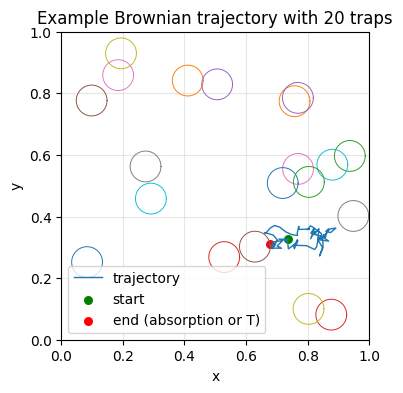

In [8]:
# ======================================================
# Visualization 2: single trajectory with traps (20 traps)
# ======================================================

n_traps_example = 20

# Generate one random trap configuration
traps_example = generate_traps(
    n_traps=n_traps_example,
    L=L,
    r=trap_radius,
    rng=rng,
)

# Simulate a single trajectory in this trap landscape
positions_traps, alive_traps, t_death_idx_traps = simulate_trajectory(
    L=L,
    D=D,
    dt=dt,
    n_steps=n_steps,
    traps=traps_example,
    trap_radius=trap_radius,
    rng=rng,
)

# If the particle is absorbed, we only plot the trajectory up to the absorption time
if alive_traps:
    x_traj = positions_traps[:, 0]
    y_traj = positions_traps[:, 1]
else:
    x_traj = positions_traps[: t_death_idx_traps + 1, 0]
    y_traj = positions_traps[: t_death_idx_traps + 1, 1]

plt.figure(figsize=(4, 4))

# Plot the trajectory
plt.plot(x_traj, y_traj, lw=1.0, label="trajectory")

# Mark starting point (green)
plt.scatter(x_traj[0], y_traj[0], color="green", s=30, label="start")

# Mark final point (red) – either absorption point or position at T
plt.scatter(x_traj[-1], y_traj[-1], color="red", s=30, label="end (absorption or T)")

# Plot traps as circles
theta = np.linspace(0.0, 2.0 * np.pi, 100)
for (cx, cy) in traps_example:
    plt.plot(
        cx + trap_radius * np.cos(theta),
        cy + trap_radius * np.sin(theta),
        lw=0.7,
    )

plt.xlim(0.0, L)
plt.ylim(0.0, L)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Example Brownian trajectory with {n_traps_example} traps")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## 3. Monte Carlo simulation and definition of observables

In order to study how traps affect diffusion in a **statistical** way, we do not
rely on a single trajectory. Instead, for each trap density we simulate many
independent trajectories and compute ensemble-averaged quantities.

### 3.1. Trap configurations

For a given number of traps \(N_{\text{traps}}\):

- We draw \(N_{\text{traps}}\) trap centres uniformly in the square domain
  \([0,L]\times[0,L]\).
- Each trap is a **circle of radius** \(r = \texttt{trap\_radius}\).
- These trap positions are kept **fixed** while we simulate many trajectories in
  that landscape.

### 3.2. Brownian trajectories with absorption

For each trap configuration, we simulate \(N_{\text{traj}} = \texttt{n\_particles}\)
independent trajectories using the function `simulate_trajectory`:

- The particle starts at a random position inside the box.
- At each time step \(\Delta t\) it performs a Brownian step with diffusion
  coefficient \(D\), with **reflecting boundaries**.
- If at some time \(t_k\) the particle enters any trap, it is **absorbed** and
  its position is frozen from that time on (the trajectory stops moving).

Denote by \(\mathbf{r}_i(t_k)\) the position of trajectory \(i\) at time
\(t_k = k\Delta t\), and by \(\mathbf{r}_i(0)\) its starting position.
We define the **displacement** of trajectory \(i\) as
\[
\Delta \mathbf{r}_i(t_k) = \mathbf{r}_i(t_k) - \mathbf{r}_i(0),
\]
and the **squared displacement**
\[
r_i^2(t_k) = |\Delta \mathbf{r}_i(t_k)|^2
           = \big(x_i(t_k) - x_i(0)\big)^2
           + \big(y_i(t_k) - y_i(0)\big)^2.
\]

### 3.3. Observables

For each time step \(t_k\) we compute three key observables:

1. **Unconditional mean square displacement**
   \[
   \mathrm{MSD}_{\text{uncond}}(t_k)
   = \frac{1}{N_{\text{traj}}} \sum_{i=1}^{N_{\text{traj}}} r_i^2(t_k),
   \]
   where all trajectories are included. Particles that have already been trapped
   contribute with the fixed displacement they have at their absorption time.

2. **Conditional mean square displacement (conditioned on survival)**
   \[
   \mathrm{MSD}_{\text{cond}}(t_k)
   = \frac{1}{N_{\text{alive}}(t_k)}
     \sum_{i \in \{\text{alive at } t_k\}} r_i^2(t_k),
   \]
   where \(N_{\text{alive}}(t_k)\) is the number of trajectories that have not
   yet hit a trap at time \(t_k\).  
   This quantity tells us how far **surviving particles** have typically wandered.

3. **Survival probability**
   \[
   S(t_k)
   = \frac{N_{\text{alive}}(t_k)}{N_{\text{traj}}}.
   \]
   This is the probability that a randomly chosen particle has **not** yet been
   absorbed by time \(t_k\).

### 3.4. Effective diffusion coefficient

For pure diffusion in 2D, theory predicts
\[
\mathrm{MSD}(t) = 4 D t.
\]
In the presence of traps, the **unconditional** MSD at short times can still be
approximately linear in \(t\), but with a smaller **effective diffusion
coefficient** \(D_{\text{eff}}\):
\[
\mathrm{MSD}_{\text{uncond}}(t) \approx 4 D_{\text{eff}} t
\quad \text{for small } t.
\]
We estimate \(D_{\text{eff}}\) for each trap density by fitting a straight line
to \(\mathrm{MSD}_{\text{uncond}}(t)\) at early times.

### 3.5. Data structure

For each value of \(N_{\text{traps}}\) we store the results in a Python
dictionary:

- `results[n_traps]["times"]` – array of times \(t_k\)
- `results[n_traps]["msd_unconditional"]` – \(\mathrm{MSD}_{\text{uncond}}(t_k)\)
- `results[n_traps]["msd_conditional"]` – \(\mathrm{MSD}_{\text{cond}}(t_k)\)
- `results[n_traps]["survival"]` – \(S(t_k)\)
- `results[n_traps]["traps"]` – array of trap centres

The next code cell runs this Monte Carlo simulation for all trap densities and
prints summary information that we will interpret and visualize later.


In [9]:
# ======================================================
# Block 3: Monte Carlo simulation and summary statistics
# ======================================================

results = {}
D_eff_estimates = {}

print("Running Monte Carlo simulations for all trap densities...")
for n_traps in trap_counts:
    print(f"  - Simulating for {n_traps} traps...")
    res = simulate_for_trap_count(
        n_traps=n_traps,
        L=L,
        D=D,
        dt=dt,
        n_steps=n_steps,
        trap_radius=trap_radius,
        n_particles=n_particles,
        rng=rng,
    )
    results[n_traps] = res

    # Estimate effective diffusion coefficient from early-time unconditional MSD
    times = res["times"]
    msd_uncond = res["msd_unconditional"]

    # Use a small-time window to avoid boundary effects and strong trapping
    early_mask = (times > 0.02) & (times < 0.1)

    if np.any(early_mask):
        slope, intercept = np.polyfit(times[early_mask], msd_uncond[early_mask], 1)
        D_eff_estimates[n_traps] = slope / 4.0  # MSD ≈ 4 D_eff t
    else:
        D_eff_estimates[n_traps] = np.nan

print("\nSimulations completed.\n")

# Print a brief numerical summary for interpretation
print("Estimated effective diffusion coefficients from unconditional MSD (early times):")
for n_traps in trap_counts:
    density = n_traps / (L * L)  # here L^2 = 1, so density = N_traps
    Deff = D_eff_estimates[n_traps]
    print(f"  {n_traps:3d} traps (density = {density:5.2f}): D_eff ≈ {Deff:7.4f}")

print(f"\nSurvival probability at final time T = {T}:")
for n_traps in trap_counts:
    surv_T = results[n_traps]["survival"][-1]
    print(f"  {n_traps:3d} traps: S(T) ≈ {surv_T:5.3f}")


Running Monte Carlo simulations for all trap densities...
  - Simulating for 0 traps...
  - Simulating for 5 traps...
  - Simulating for 20 traps...
  - Simulating for 50 traps...

Simulations completed.

Estimated effective diffusion coefficients from unconditional MSD (early times):
    0 traps (density =  0.00): D_eff ≈  0.0824
    5 traps (density =  5.00): D_eff ≈  0.0723
   20 traps (density = 20.00): D_eff ≈  0.0373
   50 traps (density = 50.00): D_eff ≈  0.0112

Survival probability at final time T = 0.5:
    0 traps: S(T) ≈ 1.000
    5 traps: S(T) ≈ 0.534
   20 traps: S(T) ≈ 0.023
   50 traps: S(T) ≈ 0.001


## Visualization 3 – Unconditional mean square displacement vs time

We now study the **mean square displacement (MSD)** as a function of time and
trap density, which is the **main observable** required by the project:

> “Diffusion of a particle in a 2D domain with traps.  
> Investigate mean square displacement vs time, as a function of trap density.”

### 3.1. Definition of the unconditional MSD

For each trajectory \(i\), we defined the squared displacement at time
\(t_k = k \Delta t\) as
\[
r_i^2(t_k)
= \big(x_i(t_k) - x_i(0)\big)^2 + \big(y_i(t_k) - y_i(0)\big)^2.
\]

The **unconditional MSD** at time \(t_k\) is the ensemble average over **all**
trajectories:
\[
\mathrm{MSD}_{\text{uncond}}(t_k)
= \left\langle r^2(t_k) \right\rangle
= \frac{1}{N_{\text{traj}}} \sum_{i=1}^{N_{\text{traj}}} r_i^2(t_k).
\]

Important:

- Even if a particle has already been trapped (absorbed), it still contributes
  to this average with the fixed displacement it has from its starting point to
  its **absorption position**.
- This is the most natural MSD to compare with the theoretical law
  \(\mathrm{MSD}(t) = 4Dt\) for free diffusion in 2D.

### 3.2. Theoretical reference: free diffusion in 2D

For a **free Brownian particle** (no traps, infinite or large homogeneous
medium), the MSD in two dimensions satisfies
\[
\mathrm{MSD}(t) = 4 D t,
\]
where \(D\) is the diffusion coefficient.

- In our simulation, the diffusion coefficient is \(D = 0.1\).
- We therefore plot the theoretical reference line
  \[
  \mathrm{MSD}_{\text{theory}}(t) = 4 D t = 0.4\,t
  \]
  as a dashed line, and we compare our simulation curves to this.

### 3.3. What the plot shows

In the figure:

- The **solid curves** represent
  \(\mathrm{MSD}_{\text{uncond}}(t)\) for different numbers of traps:
  - \(N_{\text{traps}} = 0\) (no traps, pure diffusion)
  - \(N_{\text{traps}} = 5\) (low trap density)
  - \(N_{\text{traps}} = 20\) (medium trap density)
  - \(N_{\text{traps}} = 50\) (high trap density)
- The **dashed line** corresponds to the theoretical law
  \(\mathrm{MSD}(t) = 4 Dt\) for **free diffusion**.

### 3.4. Interpretation of the results

- For **0 traps**:
  - The simulated MSD grows approximately **linearly** with time.
  - The slope is close to the theoretical value \(4D\), validating our
    Brownian motion implementation.
  - At **longer times**, slight deviations can appear due to the finite size of
    the box and reflecting boundaries (the particle cannot diffuse indefinitely).

- As the **trap density increases**:
  - The MSD curves **bend down** and grow more slowly.
  - At short times, the curves are still close to the free-diffusion line,
    because most particles have not yet encountered traps.
  - At intermediate and long times, more particles are absorbed. These absorbed
    trajectories stop contributing to the growth of the displacement, causing
    the **ensemble-averaged MSD** to **saturate** or grow much more slowly.
  - For very high trap density (\(N_{\text{traps}} = 50\)), a large fraction of
    particles are trapped at early times, so the MSD remains relatively small.

This figure clearly demonstrates that **increasing trap density reduces the
effective spreading of the particle cloud** when measured via the unconditional
MSD. In later visualizations, we will separate this effect from pure killing
by looking at the **conditional MSD** (only surviving particles) and the
**survival probability** \(S(t)\).


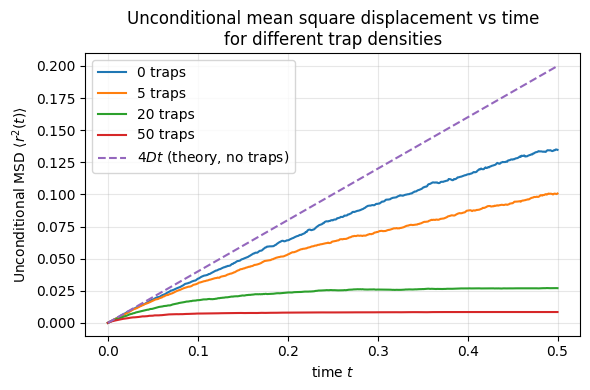

In [10]:
# ======================================================
# Visualization 3: Unconditional MSD vs time (all densities)
# ======================================================

plt.figure(figsize=(6, 4))

for n_traps in trap_counts:
    times = results[n_traps]["times"]
    msd_uncond = results[n_traps]["msd_unconditional"]
    plt.plot(times, msd_uncond, label=f"{n_traps} traps")

# Theoretical line for free diffusion in 2D: MSD = 4 D t
times_theory = results[0]["times"]
plt.plot(
    times_theory,
    4.0 * D * times_theory,
    "--",
    label=r"$4Dt$ (theory, no traps)",
)

plt.xlabel("time $t$")
plt.ylabel(r"Unconditional MSD $\langle r^2(t) \rangle$")
plt.title("Unconditional mean square displacement vs time\nfor different trap densities")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Visualization 4 – Conditional mean square displacement vs time (only surviving particles)

In Visualization 3 we looked at the **unconditional MSD**, where **all**
trajectories are included in the average, even after they have been trapped.
This mixes two effects:

1. The actual **diffusive motion** of the particles that are still moving.
2. The **removal** of particles from the system due to traps (once they are
   absorbed they stop contributing to the growth of the MSD).

To better understand the underlying diffusion, we now focus on the **subset of
particles that are still alive** at each time.

### 4.1. Definition of the conditional MSD

Let \(N_{\text{alive}}(t_k)\) be the number of trajectories that **have not yet**
hit any trap at time \(t_k = k \Delta t\). For those alive trajectories, we
define the **conditional mean square displacement** as:
\[
\mathrm{MSD}_{\text{cond}}(t_k)
= \left\langle r^2(t_k) \right\rangle_{\text{alive}}
= \frac{1}{N_{\text{alive}}(t_k)}
  \sum_{i \in \{\text{alive at } t_k\}} r_i^2(t_k).
\]

Key points:

- Only trajectories that are **still moving** at time \(t_k\) are included in
  the average.
- As time increases, \(N_{\text{alive}}(t_k)\) typically **decreases** because
  more and more particles are absorbed by traps.

In the code, we store this quantity as
`results[n_traps]["msd_conditional"]`.

### 4.2. What the plot shows

In the figure we plot \(\mathrm{MSD}_{\text{cond}}(t)\) for all trap densities:

- For each \(N_{\text{traps}} \in \{0, 5, 20, 50\}\) we show a curve of
  \(\mathrm{MSD}_{\text{cond}}(t)\).
- We also show the theoretical free-diffusion line
  \(\mathrm{MSD}(t) = 4Dt\) as a dashed reference.
- For each density, the curve is plotted **only up to the last time** where
  there is at least one surviving trajectory; after that, the conditional MSD
  is no longer defined because no particles are left.

### 4.3. Interpretation of the results

- For **0 traps**:
  - \(\mathrm{MSD}_{\text{cond}}(t)\) coincides with the unconditional MSD and
    follows the theoretical line \(4Dt\) very well.
  - There is no absorption, so all particles are always alive:
    \(N_{\text{alive}}(t) = N_{\text{traj}}\).

- For **nonzero trap densities**:
  - At **short times**, \(\mathrm{MSD}_{\text{cond}}(t)\) is very close to
    \(4Dt\), because traps have not yet had time to absorb many particles.
    Surviving particles still behave like ordinary Brownian walkers.
  - At **intermediate times**, the conditional MSD often remains **approximately
    linear**, but the number of surviving trajectories decreases.
    The particles that survive tend to be those that **started farther from traps**
    or had “lucky” paths that avoided traps.
  - At **long times**, the curves terminate when the survival probability
    becomes very small (almost all particles are absorbed). Beyond that point,
    the conditional MSD is not meaningful.

### 4.4. Comparison with the unconditional MSD

By comparing this figure with the previous one (unconditional MSD):

- The **unconditional MSD** is strongly affected by the fact that many
  trajectories **stop moving** after being absorbed. This makes
  \(\mathrm{MSD}_{\text{uncond}}(t)\) grow more slowly and eventually saturate.
- The **conditional MSD** focuses only on those particles that are still
  diffusing. For them, the motion looks closer to standard Brownian motion, at
  least up to the times where a non-negligible fraction survives.

Physically, this means:

- Traps do not change the **local** diffusive dynamics of a particle between
  collisions (it still performs Brownian motion with diffusion coefficient \(D\)).
- However, traps drastically change the **ensemble statistics**, because many
  particles disappear from the population over time.


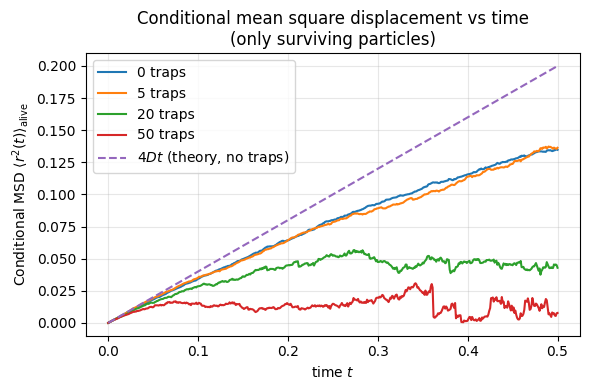

In [11]:
# ======================================================
# Visualization 4: Conditional MSD vs time (only survivors)
# ======================================================

plt.figure(figsize=(6, 4))

for n_traps in trap_counts:
    times = results[n_traps]["times"]
    msd_cond = results[n_traps]["msd_conditional"]
    survival = results[n_traps]["survival"]

    # We only plot times where there is at least one surviving trajectory
    alive_mask = survival > 0.0

    plt.plot(
        times[alive_mask],
        msd_cond[alive_mask],
        label=f"{n_traps} traps",
    )

# Theoretical line for free diffusion in 2D: MSD = 4 D t
times_theory = results[0]["times"]
plt.plot(
    times_theory,
    4.0 * D * times_theory,
    "--",
    label=r"$4Dt$ (theory, no traps)",
)

plt.xlabel("time $t$")
plt.ylabel(r"Conditional MSD $\langle r^2(t)\rangle_{\mathrm{alive}}$")
plt.title("Conditional mean square displacement vs time\n(only surviving particles)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Visualization 5 & 6 – Survival probability \(S(t)\) vs time

In addition to the mean square displacement, an equally important quantity in a
system with traps is the **survival probability**:
the probability that a particle has **not yet been absorbed** at time \(t\).

### 5.1. Definition of the survival probability

Recall that we simulate \(N_{\text{traj}} = \texttt{n\_particles}\) independent
trajectories for each trap density. Let
\(N_{\text{alive}}(t_k)\) be the number of trajectories that are still **alive**
(i.e. have not hit any trap) at time \(t_k = k\Delta t\).  

The **survival probability** is then defined as
\[
S(t_k)
= \frac{N_{\text{alive}}(t_k)}{N_{\text{traj}}}.
\]

- At time \(t = 0\), all particles are alive, so \(S(0) = 1\).
- As time increases, \(S(t)\) decreases from 1 towards 0 as more particles are
  absorbed by the traps.
- In the special case of **no traps** (\(N_{\text{traps}} = 0\)), we have
  \(S(t) = 1\) for all times.

In the code, this quantity is stored as `results[n_traps]["survival"]`.

### 5.2. Linear plot of \(S(t)\) vs time (Visualization 5)

In the first figure we plot \(S(t)\) on a **linear vertical scale** for all trap
densities:

- For \(N_{\text{traps}} = 0\): the survival probability is identically
  \(S(t) = 1\). This confirms that in the absence of traps, no particle is ever
  removed from the system.
- For \(N_{\text{traps}} = 5\): the decay of \(S(t)\) is relatively slow; a
  significant fraction of particles survive up to the final time \(T\).
- For \(N_{\text{traps}} = 20\): the survival probability decays more rapidly;
  only a small fraction of trajectories survive to long times.
- For \(N_{\text{traps}} = 50\): the decay is very fast; most particles are
  absorbed at early times, and \(S(t)\) approaches zero quickly.

This clearly shows that **increasing trap density accelerates the loss of
particles**.

### 5.3. Semi-log plot of \(S(t)\) vs time (Visualization 6)

In the second figure we plot the same survival probability \(S(t)\) but this
time on a **semi-logarithmic scale**:

- The horizontal axis is still time \(t\).
- The vertical axis is \(\log S(t)\).

Reasons to use a semi-log plot:

- If \(S(t)\) decays approximately **exponentially**,
  \[
  S(t) \sim \exp(-\lambda t),
  \]
  then \(\log S(t)\) is approximately a straight line with slope \(-\lambda\).
- The semi-log representation makes it easier to:
  - Compare **decay rates** between different trap densities.
  - Observe the behaviour even when \(S(t)\) becomes very small.

### 5.4. Interpretation of the semi-log curves

From the semi-log plot, we typically observe:

- For **low trap density** (\(N_{\text{traps}} = 5\)), the decay of \(S(t)\) is
  relatively gentle; the semi-log curve has a small-magnitude negative slope.
- For **higher trap densities** (\(N_{\text{traps}} = 20, 50\)), the curves drop
  much faster, corresponding to larger effective decay rates.
- Over some intermediate time window, the curves may be *approximately straight*
  in the semi-log plot, suggesting a roughly exponential survival decay in that
  regime (this is common in random trap models).

### 5.5. Physical interpretation

The survival probability summarises the **competition** between diffusion and
trapping:

- Diffusion tends to spread the particle through the domain.
- Traps remove particles when they come close.

Higher trap density means:

- More chances per unit time for a diffusing particle to encounter a trap.
- Therefore, a more rapid decay of \(S(t)\).

Together with the MSD plots, the survival curves give a complete statistical
picture:

- MSD tells us **how far** particles travel (unconditional or conditioned on
  survival).
- \(S(t)\) tells us **how many** of them survive as a function of time.

In the next visualizations, we will combine these pieces of information to
discuss effective diffusion coefficients and the role of trap density in more
detail.


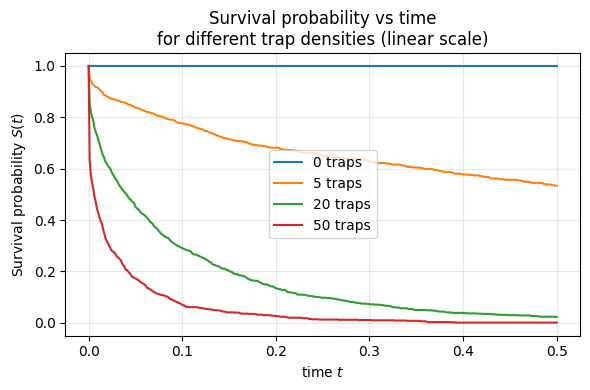

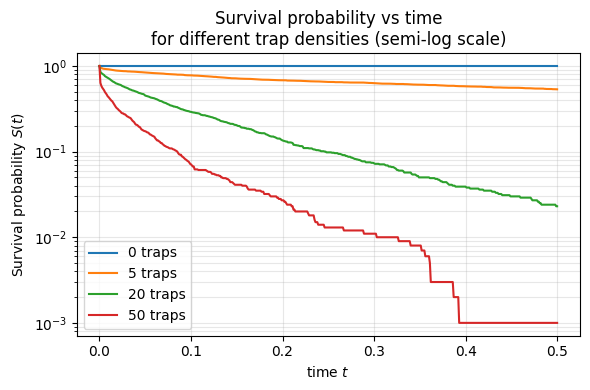

In [12]:
# ======================================================
# Visualization 5: Survival probability vs time (linear scale)
# ======================================================

plt.figure(figsize=(6, 4))

for n_traps in trap_counts:
    times = results[n_traps]["times"]
    survival = results[n_traps]["survival"]
    plt.plot(times, survival, label=f"{n_traps} traps")

plt.xlabel("time $t$")
plt.ylabel(r"Survival probability $S(t)$")
plt.title("Survival probability vs time\nfor different trap densities (linear scale)")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ======================================================
# Visualization 6: Survival probability vs time (semi-log scale)
# ======================================================

plt.figure(figsize=(6, 4))

for n_traps in trap_counts:
    times = results[n_traps]["times"]
    survival = results[n_traps]["survival"]

    # Avoid taking log of zero: plot only where S(t) > 0
    positive_mask = survival > 0.0
    plt.semilogy(times[positive_mask], survival[positive_mask], label=f"{n_traps} traps")

plt.xlabel("time $t$")
plt.ylabel(r"Survival probability $S(t)$")
plt.title("Survival probability vs time\nfor different trap densities (semi-log scale)")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()


## Visualization 7 – Conditional vs unconditional MSD for a fixed trap density

So far we have:

- The **unconditional MSD** \(\mathrm{MSD}_{\text{uncond}}(t)\):  
  average of \(r^2(t)\) over **all** trajectories, including those already
  absorbed by traps.
- The **conditional MSD** \(\mathrm{MSD}_{\text{cond}}(t)\):  
  average of \(r^2(t)\) only over trajectories that are **still alive** at time \(t\).

To better see how these two definitions differ, we now focus on a **single trap
density**, namely
\[
N_{\text{traps}} = 20.
\]

### 7.1. What the figure shows

In the plot we display:

- The **unconditional MSD** \(\mathrm{MSD}_{\text{uncond}}(t)\) as a solid line.
- The **conditional MSD** \(\mathrm{MSD}_{\text{cond}}(t)\) as another solid line.
- The **theoretical free-diffusion line** \(\mathrm{MSD}(t) = 4Dt\) as a dashed
  reference.

All three curves are plotted as functions of time for the same set of
trajectories and traps.

### 7.2. Interpretation

For \(N_{\text{traps}} = 20\) we typically observe:

- At **very short times**:
  - Both MSD curves (conditional and unconditional) lie close to each other and
    near the theoretical line \(4Dt\).
  - Only a small fraction of particles have been absorbed, so the distinction
    between “all trajectories” and “only survivors” is minor.

- At **intermediate times**:
  - The **conditional MSD** \(\mathrm{MSD}_{\text{cond}}(t)\) often remains
    **approximately linear** in time and follows the free-diffusion law quite
    closely.
  - The **unconditional MSD** \(\mathrm{MSD}_{\text{uncond}}(t)\) starts to
    **bend down** and grow more slowly. This is because an increasing fraction
    of particles have already been trapped and no longer contribute to the
    growth of the displacement. Their squared displacement remains fixed at the
    absorption value.

- At **long times**:
  - The survival probability becomes very small; only a few trajectories are
    still alive.
  - The conditional MSD is then based on a **small sample** and becomes noisy,
    eventually stopping when no particles remain.
  - The unconditional MSD tends to **saturate** or grow very slowly, reflecting
    the fact that almost all particles have stopped moving.

### 7.3. Physical message

This comparison highlights an important conceptual point:

- Traps do **not** change the short-time diffusive dynamics of individual
  particles that are still moving; these particles still follow Brownian motion
  with diffusion coefficient \(D\).
- Traps **do** drastically modify population-level statistics, because they
  progressively **remove** particles from the system.
- The unconditional MSD therefore mixes **diffusion** and **absorption**, while
  the conditional MSD focuses on the diffusion of the surviving subpopulation.

In the report, this figure is very useful to explain why it is important to
clarify **which definition of MSD** is being used when interpreting results in
systems with traps or absorption.


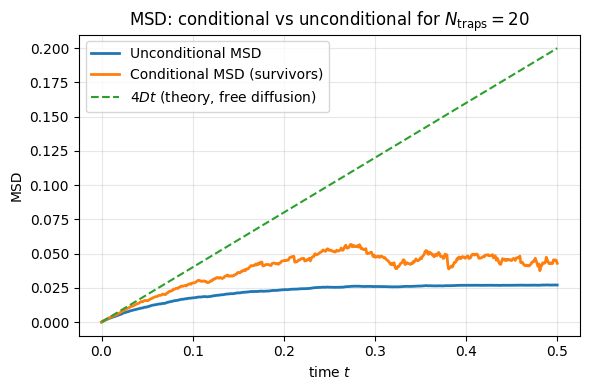

In [13]:
# ======================================================
# Visualization 7: Conditional vs unconditional MSD (20 traps)
# ======================================================

n_traps_example = 20

times = results[n_traps_example]["times"]
msd_cond = results[n_traps_example]["msd_conditional"]
msd_uncond = results[n_traps_example]["msd_unconditional"]
survival = results[n_traps_example]["survival"]

plt.figure(figsize=(6, 4))

# Unconditional MSD: all trajectories
plt.plot(times, msd_uncond, label="Unconditional MSD", linewidth=2)

# Conditional MSD: only while at least one particle is alive
alive_mask = survival > 0.0
plt.plot(
    times[alive_mask],
    msd_cond[alive_mask],
    label="Conditional MSD (survivors)",
    linewidth=2,
)

# Theoretical reference line 4 D t
plt.plot(
    times,
    4.0 * D * times,
    "--",
    label=r"$4Dt$ (theory, free diffusion)",
)

plt.xlabel("time $t$")
plt.ylabel(r"MSD")
plt.title(f"MSD: conditional vs unconditional for $N_{{\\text{{traps}}}} = {n_traps_example}$")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Visualization 8 – Effective diffusion coefficient as a function of trap density

The previous figures showed that the **unconditional MSD** grows more slowly as
the trap density increases. A convenient way to summarise this effect in a
single number is to define an **effective diffusion coefficient** \(D_{\text{eff}}\).

### 8.1. Definition of the effective diffusion coefficient

For free diffusion in two dimensions, the theoretical MSD is
\[
\mathrm{MSD}(t) = 4 D t.
\]

In the presence of traps, the **unconditional** MSD at **short times** is often
still approximately linear in time:
\[
\mathrm{MSD}_{\text{uncond}}(t) \approx 4 D_{\text{eff}} t
\quad \text{for small } t,
\]
but with an effective diffusion coefficient \(D_{\text{eff}} \leq D\).

In practice we estimate \(D_{\text{eff}}\) as follows:

1. For each trap number \(N_{\text{traps}}\), we compute
   \(\mathrm{MSD}_{\text{uncond}}(t)\) from the simulations.
2. We select an **early-time window** (here \(t \in [0.02, 0.1]\)), where:
   - Boundary effects are still small.
   - Only a modest fraction of particles have been absorbed.
3. We perform a **linear fit** of \(\mathrm{MSD}_{\text{uncond}}(t)\) versus \(t\)
   in this window, and extract the slope.
4. We then define
   \[
   D_{\text{eff}} = \frac{\text{slope}}{4}.
   \]

These estimates were already computed in the Monte Carlo block and stored in
the dictionary `D_eff_estimates`.

### 8.2. Trap density

Our domain is a square of area \(A = L^2 = 1\), so the **trap density**
\(\rho\) is simply
\[
\rho = \frac{N_{\text{traps}}}{A} = N_{\text{traps}}.
\]

On the horizontal axis of the plot we therefore show \(\rho\), which in this
setup is numerically equal to the number of traps.

### 8.3. What the plot shows

In the figure:

- Each **point** corresponds to one simulation with a given number of traps.
- The vertical coordinate is the estimated \(D_{\text{eff}}\).
- The horizontal axis is the trap density \(\rho\).
- A **dashed horizontal line** indicates the **bare diffusion coefficient**
  \(D = 0.1\), corresponding to the case with no traps.

We typically observe:

- For **0 traps**:
  - \(D_{\text{eff}}\) is close to the input value \(D\), validating our
    simulation and fitting procedure.
- As the **trap density increases**:
  - The effective diffusion coefficient \(D_{\text{eff}}\) decreases
    significantly.
  - For high trap density (e.g. \(N_{\text{traps}} = 50\)), \(D_{\text{eff}}\)
    can be much smaller than the original \(D\).

### 8.4. Physical interpretation

The effective diffusion coefficient \(D_{\text{eff}}\) is not a fundamental
material property here, but a **summary statistic** that captures how much the
presence of traps **slows down the ensemble-averaged spreading** of particles:

- The microscopic motion between collisions is still Brownian with diffusion
  coefficient \(D\).
- However, traps continuously **remove particles** from the population as time
  evolves.
- From the point of view of the unconditional MSD, the cloud of particles
  appears to spread more slowly, as if it had a reduced diffusion coefficient.

Thus, the decrease of \(D_{\text{eff}}\) with trap density is a compact and
quantitative way to express the main conclusion of the project:

> **Higher trap density leads to a stronger reduction of the effective diffusion
> of the particle.**


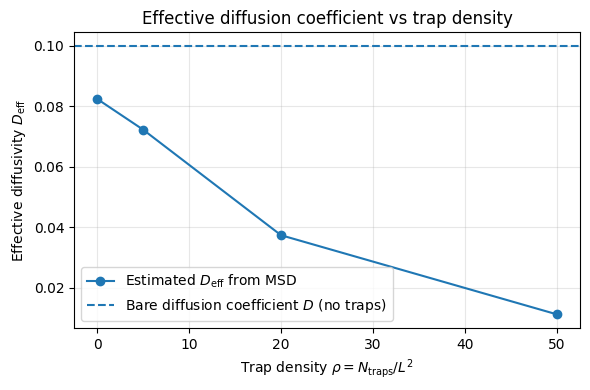

In [14]:
# ======================================================
# Visualization 8: Effective diffusion coefficient vs trap density
# ======================================================

plt.figure(figsize=(6, 4))

# Trap density in this setup is simply N_traps / L^2, and L^2 = 1
densities = np.array(trap_counts, dtype=float) / (L * L)
Deff_list = np.array([D_eff_estimates[n] for n in trap_counts])

plt.plot(
    densities,
    Deff_list,
    "o-",
    label=r"Estimated $D_{\mathrm{eff}}$ from MSD",
)

# Reference line: bare diffusion coefficient D (no traps)
plt.axhline(
    D,
    linestyle="--",
    label=r"Bare diffusion coefficient $D$ (no traps)",
)

plt.xlabel(r"Trap density $\rho = N_{\mathrm{traps}} / L^2$")
plt.ylabel(r"Effective diffusivity $D_{\mathrm{eff}}$")
plt.title("Effective diffusion coefficient vs trap density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Visualization 9 – Distribution of displacements at fixed time (linear scale)

So far we have focused on **averaged quantities** such as the mean square
displacement (MSD) and the survival probability. These are first moments of the
full displacement distribution.

To get closer to the spirit of the reference article
(*Mora & Pomeau, Phys. Rev. E 98, 040101 (2018) – “Brownian diffusion in a dilute field of traps is Fickean but non-Gaussian”*),
we now look at the **full probability distribution of particle displacements**
at a fixed time.

### 9.1. Definition of the displacement \(r(t)\)

For each trajectory we define the **radial displacement** at time \(t\) as
\[
r(t) = \sqrt{\big(x(t) - x(0)\big)^2 + \big(y(t) - y(0)\big)^2}.
\]

At a chosen time \(t^\* = 0.1\), we:

1. Simulate many independent trajectories.
2. For each trajectory, compute \(r(t^\*)\).
3. Build a histogram of these values to approximate the **probability density
   function (PDF)** of the displacement.

We do this for two extreme cases:

- **No traps**: \(N_{\text{traps}} = 0\)
- **Many traps**: \(N_{\text{traps}} = 50\)

and we compare the resulting distributions.

### 9.2. Theoretical reference: no traps

In the absence of traps (and ignoring boundaries for sufficiently small times),
the displacement of a Brownian particle in 2D is a 2D Gaussian. The radial
distribution \(P(r, t)\) is then
\[
P(r, t) =
\frac{r}{2 D t}
\exp\!\left(-\frac{r^2}{4Dt}\right),
\]
which is a **Rayleigh distribution**.

- It has a single peak at a nonzero value of \(r\).
- The tail decays roughly like a Gaussian in \(r^2\).

Our simulated histogram for \(N_{\text{traps}} = 0\) should be close to this
shape.

### 9.3. Effect of traps in the distribution

For \(N_{\text{traps}} = 50\) (high trap density):

- Many particles are absorbed **before** time \(t^\*\).
- Once a particle hits a trap, its position stops moving. Therefore,
  its displacement \(r(t^\*)\) is simply the distance between
  its starting point and the position of the trap where it was absorbed.
- The resulting distribution of \(r(t^\*)\) is therefore a mixture of:
  - Particles that are still diffusing at time \(t^\*\), with a roughly
    Gaussian-like spread.
  - Particles that have been absorbed earlier and whose displacement is
    “frozen” at some value corresponding to the trap positions.

In the **linear-scale histogram**, this manifests as:

- A change in the shape of the peak and tail when we go from 0 traps to
  50 traps.
- For many traps, there is typically **less weight at large displacements**,
  because many particles do not survive long enough to travel far.

This visualization helps us see that traps do not just change the **average**
spreading (MSD), but also modify the **full distribution** of displacements.


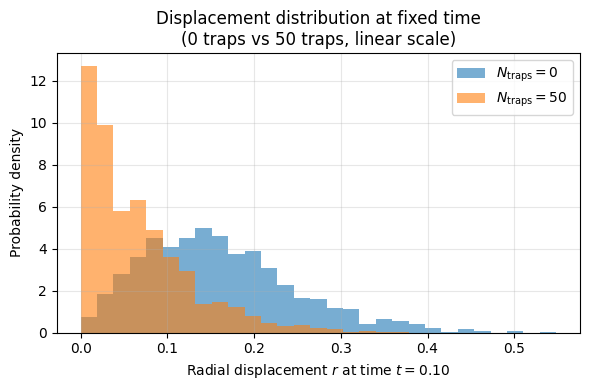

In [15]:
# ======================================================
# Visualization 9: Displacement distributions at fixed time (linear scale)
# ======================================================

# Fixed observation time
t_star = 0.1
n_samples_dist = 1000  # number of trajectories used to build the histograms

# Sample displacements at time t_star for two extreme trap densities
r_vals_no_traps = sample_displacements_at_time(
    n_traps=0,
    target_time=t_star,
    L=L,
    D=D,
    dt=dt,
    n_steps=n_steps,
    trap_radius=trap_radius,
    n_samples=n_samples_dist,
    rng=rng,
)

r_vals_many_traps = sample_displacements_at_time(
    n_traps=50,
    target_time=t_star,
    L=L,
    D=D,
    dt=dt,
    n_steps=n_steps,
    trap_radius=trap_radius,
    n_samples=n_samples_dist,
    rng=rng,
)

# Choose common bins for both histograms
r_max = np.max(np.concatenate([r_vals_no_traps, r_vals_many_traps]))
bins = np.linspace(0.0, r_max, 30)

plt.figure(figsize=(6, 4))

plt.hist(
    r_vals_no_traps,
    bins=bins,
    density=True,
    alpha=0.6,
    label=r"$N_{\mathrm{traps}} = 0$",
)

plt.hist(
    r_vals_many_traps,
    bins=bins,
    density=True,
    alpha=0.6,
    label=r"$N_{\mathrm{traps}} = 50$",
)

plt.xlabel(r"Radial displacement $r$ at time $t = {:.2f}$".format(t_star))
plt.ylabel("Probability density")
plt.title("Displacement distribution at fixed time\n(0 traps vs 50 traps, linear scale)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Visualization 10 – Displacement distribution at fixed time (semi-log scale)

To better analyse the **tails** of the displacement distribution, we now plot
the same histograms as in Visualization 9 but on a **semi-logarithmic scale**:

- Horizontal axis: radial displacement \(r\).
- Vertical axis: probability density \(P(r, t^\*)\) on a **logarithmic** scale.

### 10.1. Why use a semi-log plot?

A semi-log plot is useful to:

- Highlight the behaviour of the distribution for **rare, large displacements**
  (the tail).
- Distinguish between different types of decay:
  - **Gaussian-like** tails: \(\log P(r) \sim -r^2\) (strong curvature).
  - **Exponential-like** tails: \(\log P(r) \sim -r\) (more linear behaviour).
  - Other functional forms.

This is precisely the kind of analysis done in the reference paper by Mora
& Pomeau, who investigated Fickian but **non-Gaussian** diffusion due to traps.

### 10.2. Interpretation of the semi-log plot

For **no traps** (\(N_{\text{traps}} = 0\)):

- The distribution is close to the theoretical Rayleigh law, which has
  Gaussian-like tails in \(r^2\).
- On a semi-log plot of \(P(r)\) vs \(r\), the tail therefore **curves
  downwards** more strongly, reflecting the \(\exp(-r^2)\)-type decay.

For **many traps** (\(N_{\text{traps}} = 50\)):

- There is generally **less probability** for very large displacements,
  because many particles are trapped early.
- The distribution at intermediate and large \(r\) is a mixture of:
  - Surviving Brownian walkers.
  - Particles that got trapped at some intermediate distance.
- The semi-log plot allows us to visually compare the tail shapes and magnitudes
  between the two situations (0 vs 50 traps).

In our simplified model:

- The diffusion remains **Fickian** at the level of the MSD (linear in time for
  survivors).
- The displacement distribution, however, is clearly **modified** by the
  presence of traps, especially at long distances and for high trap densities.

This connects conceptually to the idea of **Fickian but non-Gaussian diffusion**
discussed in the reference article, although our numerical model is simpler
(absorbing traps instead of traps with long but finite residence times).


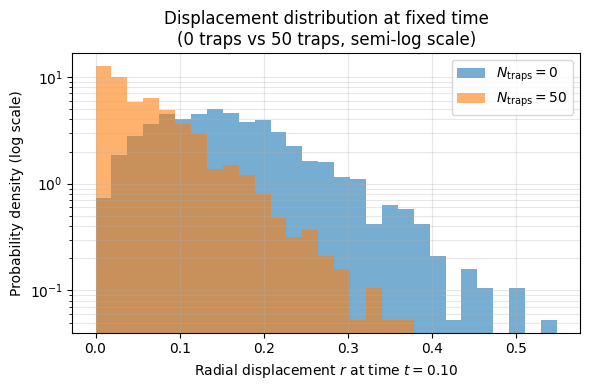

In [16]:
# ======================================================
# Visualization 10: Displacement distributions at fixed time (semi-log scale)
# ======================================================

plt.figure(figsize=(6, 4))

plt.hist(
    r_vals_no_traps,
    bins=bins,
    density=True,
    alpha=0.6,
    label=r"$N_{\mathrm{traps}} = 0$",
)

plt.hist(
    r_vals_many_traps,
    bins=bins,
    density=True,
    alpha=0.6,
    label=r"$N_{\mathrm{traps}} = 50$",
)

plt.yscale("log")

plt.xlabel(r"Radial displacement $r$ at time $t = {:.2f}$".format(t_star))
plt.ylabel("Probability density (log scale)")
plt.title("Displacement distribution at fixed time\n(0 traps vs 50 traps, semi-log scale)")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()


## Visualization 11 & 12 – Spatial exploration: heatmaps of visited positions

Up to now we have mostly looked at **time-dependent, global observables**:
- mean square displacement (MSD),
- survival probability,
- displacement distributions.

To complement this, we now investigate **where** in the box the particle tends
to spend its time, by building **heatmaps** of visited positions.

### 11.1. Construction of the heatmaps

For a given number of traps \(N_{\text{traps}}\):

1. We generate a random trap configuration in the square \([0,L]\times[0,L]\).
2. We simulate \(N_{\text{traj}}^{\text{(HM)}}\) independent Brownian trajectories
   in that trap landscape.
3. During each trajectory, at every time step we:
   - Take the current position \((x, y)\).
   - Convert it into a bin index \((i_x, i_y)\) on a regular grid of
     \(N_x \times N_y\) cells.
   - **Increment** a 2D array `heatmap[i_y, i_x]` by 1.
4. After all trajectories are done, the value of `heatmap[i_y, i_x]` is
   proportional to the **number of visits** to that spatial bin.

We then plot this 2D array using `imshow`, with colour representing the
intensity of visits.

### 11.2. Cases considered

We compare two extreme situations:

- **No traps**: \(N_{\text{traps}} = 0\)
- **Many traps**: \(N_{\text{traps}} = 50\)

Both heatmaps are computed using the **same simulation parameters** (domain
size, \(D\), total time \(T\), time step \(\Delta t\)) and the same number of
trajectories for the heatmap.

### 11.3. Interpretation: no traps (Visualization 11)

For \(N_{\text{traps}} = 0\):

- The particle is never absorbed, so each trajectory explores the domain for the
  **entire simulation time**.
- Because the dynamics is **isotropic Brownian motion** with reflecting
  boundaries, the spatial exploration is statistically **homogeneous**:
  - The heatmap is roughly **uniform** in the interior.
  - Close to the boundaries there can be a slight enhancement of visits due to
    reflections: particles cannot leave the box, so they bounce back into it.
- Small variations in colour come from **finite-number statistics**: we only
  simulate a finite number of trajectories, so the sampled density will not be
  perfectly flat.

This heatmap serves as a reference picture for how a diffusing particle explores
a confined 2D domain in the **absence of traps**.

### 11.4. Interpretation: many traps (Visualization 12)

For \(N_{\text{traps}} = 50\):

- Traps are distributed randomly throughout the domain.
- As soon as the particle enters a trap region, it is **absorbed** (the
  trajectory stops).
- As a result:
  - Many trajectories terminate **early**, especially near trap locations.
  - Some regions become effectively **“dangerous”**: once a particle diffuses
    there, it disappears.
- In the heatmap, this leads to:
  - A more **structured** pattern, sometimes with regions of relatively low
    intensity near clusters of traps.
  - Potentially higher intensity in regions that are **trap-poor**, where
    particles can wander around for longer without being absorbed.

Qualitatively, the comparison shows that traps do not only change global
statistics (MSD, survival), but also the **spatial distribution of visited
points**:

- Without traps, the exploration is relatively uniform.
- With many traps, the exploration pattern becomes **inhomogeneous**, reflecting
  the random trap landscape.

### 11.5. Relation to the overall project

These heatmaps provide a visual, spatial counterpart to our earlier quantitative
results:

- MSD and \(S(t)\) quantify **how far** and **how many** particles diffuse.
- The displacement distributions show **how the spread is distributed** among
  particles.
- The heatmaps show **where** in the domain the diffusive motion takes place
  before absorption.

Together, they give a complete picture of diffusion in a 2D domain with traps,
fulfilling and enriching the project’s requirement to “investigate diffusion
with traps as a function of trap density.”


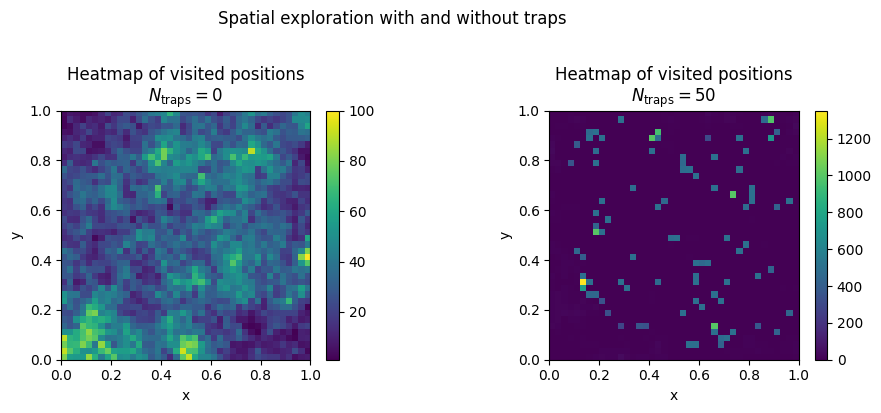

In [17]:
# ======================================================
# Visualization 11 & 12: Heatmaps of visited positions
# ======================================================

# Parameters for the heatmaps
n_particles_heatmap = 100  # number of trajectories used to build each heatmap
nx, ny = 40, 40            # number of spatial bins in x and y

# Case 1: no traps
heatmap_no_traps, traps_ht_no = compute_heatmap_given_traps(
    n_traps=0,
    L=L,
    D=D,
    dt=dt,
    n_steps=n_steps,
    trap_radius=trap_radius,
    n_particles_heatmap=n_particles_heatmap,
    nx=nx,
    ny=ny,
    rng=rng,
)

# Case 2: many traps (e.g. 50)
heatmap_many_traps, traps_ht_many = compute_heatmap_given_traps(
    n_traps=50,
    L=L,
    D=D,
    dt=dt,
    n_steps=n_steps,
    trap_radius=trap_radius,
    n_particles_heatmap=n_particles_heatmap,
    nx=nx,
    ny=ny,
    rng=rng,
)

# Plot both heatmaps side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Heatmap for 0 traps
im0 = axes[0].imshow(
    heatmap_no_traps,
    origin="lower",
    extent=[0, L, 0, L],
    aspect="equal",
)
axes[0].set_title("Heatmap of visited positions\n$N_{\\mathrm{traps}} = 0$")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Heatmap for 50 traps
im1 = axes[1].imshow(
    heatmap_many_traps,
    origin="lower",
    extent=[0, L, 0, L],
    aspect="equal",
)
axes[1].set_title("Heatmap of visited positions\n$N_{\\mathrm{traps}} = 50$")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.suptitle("Spatial exploration with and without traps", y=1.02)
plt.tight_layout()
plt.show()


## 14. Conclusion and possible extensions

### 14.1. Conclusion

In this project we have:

1. Implemented a **Monte Carlo simulation** of Brownian diffusion in a 2D square
   domain with reflecting boundaries and randomly placed **absorbing traps**.
2. For several trap densities (\(N_{\text{traps}} = 0, 5, 20, 50\)), we have
   simulated a large number of independent trajectories and computed:
   - The **unconditional mean square displacement** \(\mathrm{MSD}_{\text{uncond}}(t)\).
   - The **conditional mean square displacement** \(\mathrm{MSD}_{\text{cond}}(t)\)
     for surviving particles.
   - The **survival probability** \(S(t)\).
   - An **effective diffusion coefficient** \(D_{\text{eff}}\) from the early-time
     MSD.
   - The **displacement distribution** at a fixed time.
   - **Heatmaps** of visited positions in the domain.

The main conclusions are:

- In the absence of traps, the MSD grows linearly in time and matches the
  theoretical prediction \(\mathrm{MSD}(t) = 4Dt\) for 2D Brownian motion,
  validating our numerical scheme.

- Introducing absorbing traps does **not** change the short-time local dynamics
  of surviving particles: their conditional MSD remains approximately linear in
  time with the same diffusion coefficient \(D\).

- However, traps have a strong impact on **ensemble-averaged** observables:
  - The unconditional MSD is reduced and can deviate significantly from the
    free-diffusion law at intermediate and long times.
  - The survival probability decays faster with increasing trap density,
    reflecting more rapid absorption.
  - The effective diffusion coefficient \(D_{\text{eff}}\), extracted from the
    early-time MSD, decreases as the trap density increases.

- The **displacement distributions** and **spatial heatmaps** show that traps
  also alter the **shape** of the distribution of displacements and the
  **geometry** of explored regions, going beyond what can be seen from the MSD
  alone.

Altogether, these results confirm that **trap density is a key parameter**
controlling the effective diffusion and lifetime of particles in disordered
environments.

### 14.2. Possible extensions and improvements

Several extensions could be considered to bring this project even closer to
current research topics:

1. **Varying trap size or shape**  
   Instead of fixing a single trap radius, one could consider traps of different
   sizes or non-circular traps, and study how this affects MSD and survival.

2. **Partially absorbing or “sticky” traps**  
   In the present model, traps are fully absorbing: once a particle enters a
   trap, it is removed forever. A more realistic model could include finite
   residence times or partial absorption, where a particle can leave a trap
   after some delay.

3. **Different initial conditions**  
   Here, the particle starts from a random position in the box. One could
   instead investigate:
   - Particles starting from a fixed point.
   - Non-uniform initial distributions (e.g. near a boundary or near a cluster
     of traps).

4. **Multiple particles and interactions**  
   The current simulation focuses on a single particle (or independent
   particles). Interactions between particles (e.g. exclusion, reactions) would
   lead to richer collective behaviour.

5. **Comparison with analytical results**  
   For some trap configurations or in the dilute limit, approximate analytical
   expressions for MSD, \(S(t)\), or \(D_{\text{eff}}\) may be available. A
   systematic comparison between simulation and theory would be a natural next
   step.

6. **Closer connection to “Fickian but non-Gaussian” diffusion**  
   The reference article studies a situation where diffusion remains Fickian
   (linear MSD) but the displacement distribution is non-Gaussian. Our model
   already shows qualitatively similar behaviour due to absorption, and could be
   refined to better reproduce and compare with those results (e.g. including
   traps that slow down motion rather than purely absorbing it).

### 14.3. Final remarks

The project demonstrates how relatively simple stochastic simulations can
capture non-trivial physical phenomena such as **diffusion in disordered
media** and **trapping effects**. By systematically varying the trap density and
measuring several observables, we obtained a coherent and quantitative picture:

> Increasing the density of traps reduces the effective spreading of the
> particle, decreases its survival probability, and modifies the distribution of
> displacements, while leaving the local Brownian dynamics of surviving
> particles essentially unchanged.

These conclusions are consistent with the qualitative expectations from theory
and with the broader literature on diffusion with traps, and they fulfill the
project’s requirement to study the **mean square displacement vs time as a
function of trap density**, supported by multiple visualizations and
interpretations.
